In [1]:
import os

# Get the directory containing the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Change working directory to notebook folder
os.chdir(notebook_dir)

# Verify
print("Current working directory:", os.getcwd())

Current working directory: /home/j/jl1416/sta521/521PredictionProject-1


<Figure size 1000x800 with 0 Axes>

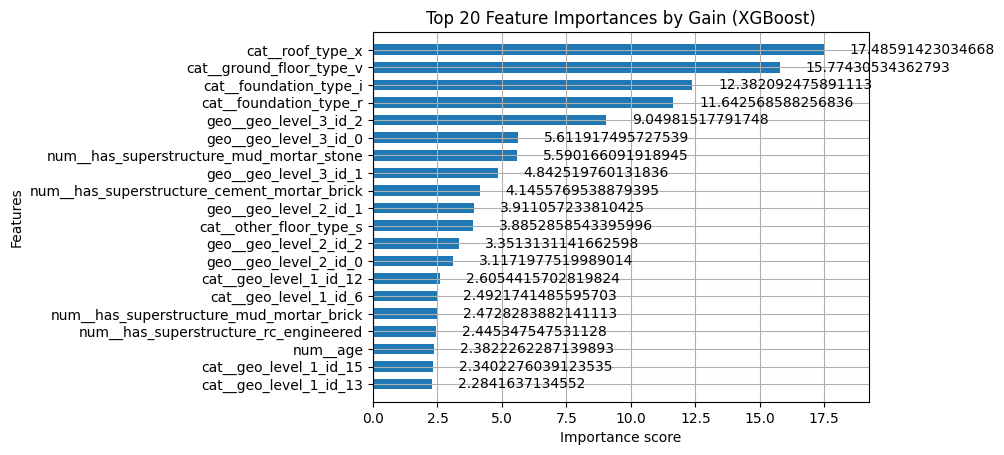

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import plot_importance
import pickle

# Load trained XGBoost model
with open("artifacts/final_model_xgb.pkl", "rb") as f:
    model = pickle.load(f)

# Load target encoder
with open("artifacts/final_target_encoder.pkl", "rb") as f:
    te_final = pickle.load(f)


# Plot top 20 features by Gain
plt.figure(figsize=(10, 8))
plot_importance(
    model,
    importance_type='gain',  # use Gain instead of Weight
    max_num_features=20,
    height=0.6
)
plt.title("Top 20 Feature Importances by Gain (XGBoost)")
plt.show()

In [3]:
# ------------------------------------------
# 1. Load model + training data
# ------------------------------------------
from sklearn.preprocessing import TargetEncoder 

# Load training data (modify path if needed)
X_train = pd.read_csv("data/cleaned/train_cleaned.csv")
X_sample = X_train.sample(1000, random_state=42)
y_sample = X_sample['damage_grade']
X_sample = X_sample.drop(columns=['damage_grade'])

# Features to target‐encode
geo_target = ['geo__geo_level_2_id', 'geo__geo_level_3_id']

# -----------------------------
# Train final model on full train set with target encoding
# -----------------------------
X_sample_enc = te_final.transform(X_sample[geo_target])

X_sample_enc = pd.DataFrame(X_sample_enc, index=X_sample.index, columns=te_final.get_feature_names_out(geo_target))

X_sample_full = X_sample.copy()
X_sample_full.drop(columns=geo_target, inplace=True)

X_sample_full = pd.concat([X_sample_full, X_sample_enc], axis=1)


In [4]:
import shap

# ------------------------------------------
# 3. Align features exactly with model
# ------------------------------------------
model_features = model.get_booster().feature_names
X_sample_full_aligned = X_sample_full[model_features]

# Use the XGBClassifier directly
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample_full_aligned)

# Check type
print(type(shap_values))  # Should be a list (one array per class)
print([v.shape for v in shap_values])



<class 'numpy.ndarray'>
[(102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102, 3), (102,


--- Generating Summary Plot (Mean Absolute SHAP across all classes) ---


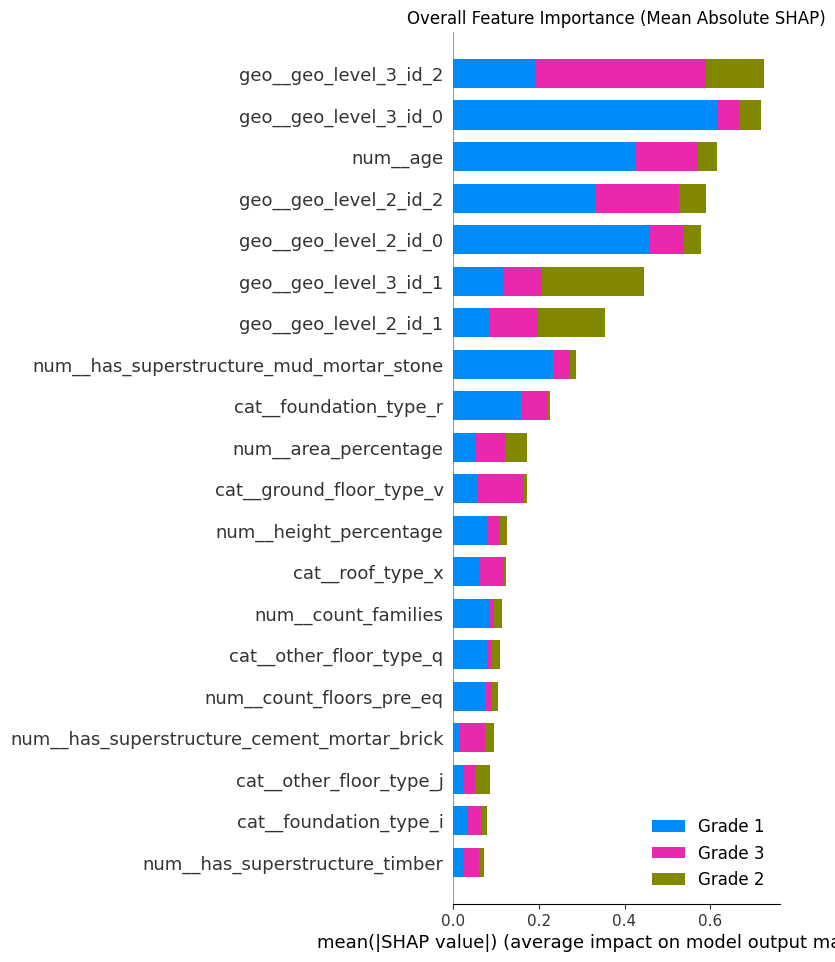

In [5]:
## SHAP Summary Plot
print("\n--- Generating Summary Plot (Mean Absolute SHAP across all classes) ---")
shap.summary_plot(
    shap_values,                 
    X_sample_full_aligned,       
    plot_type="bar",             
    class_names=['Grade 1', 'Grade 2', 'Grade 3'], 
    show=False                   
)
plt.title("Overall Feature Importance (Mean Absolute SHAP)")
plt.show()

## SHAP for interpretation

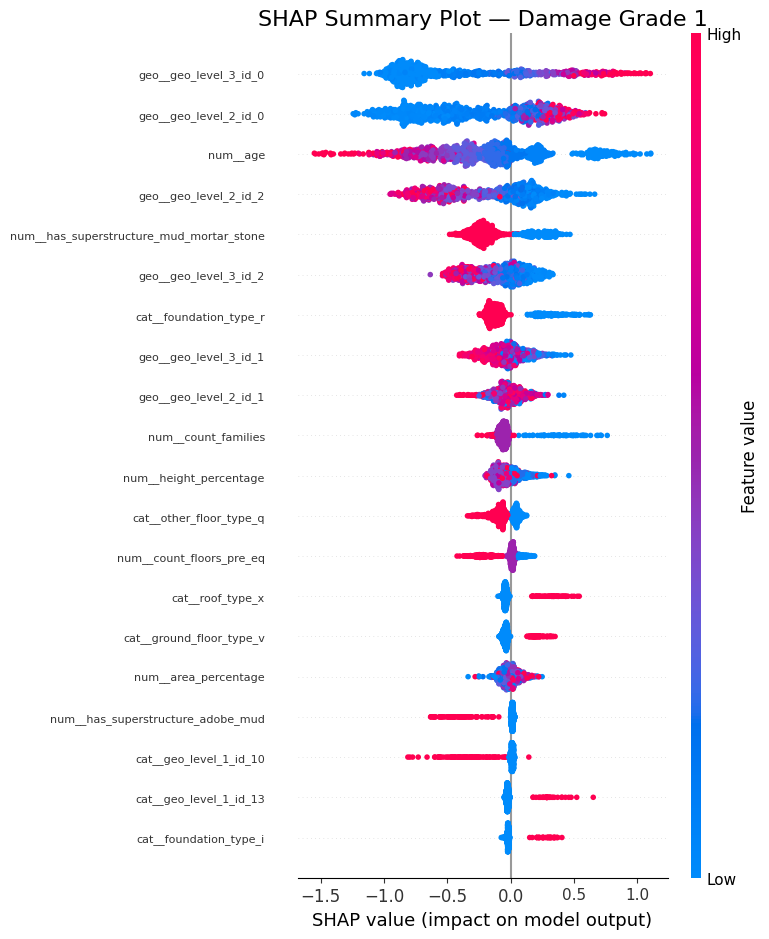

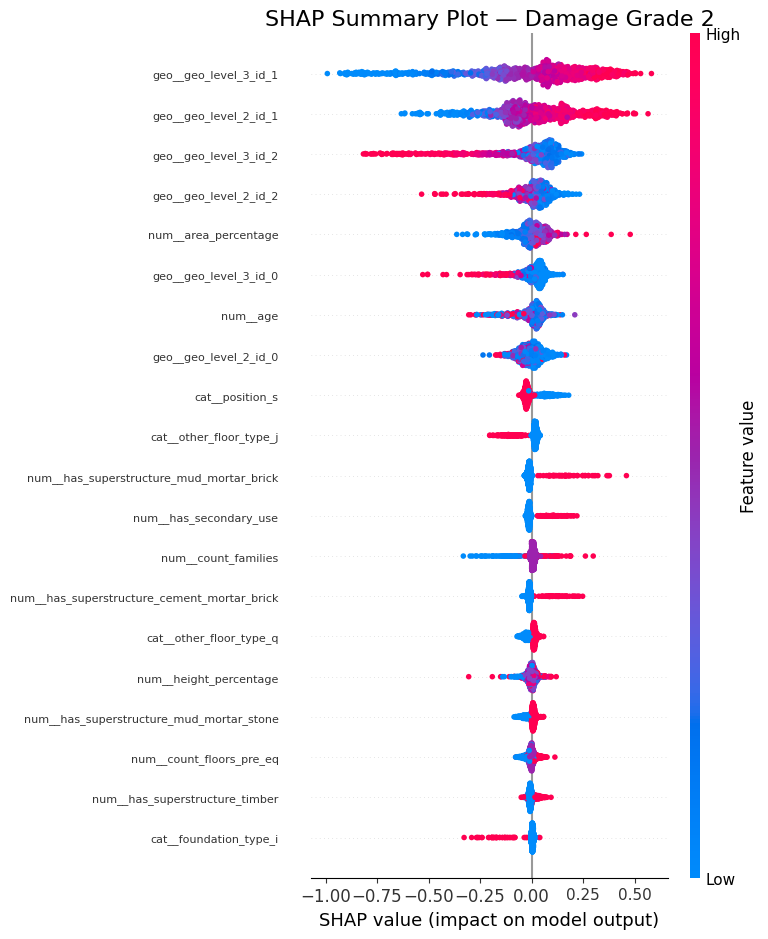

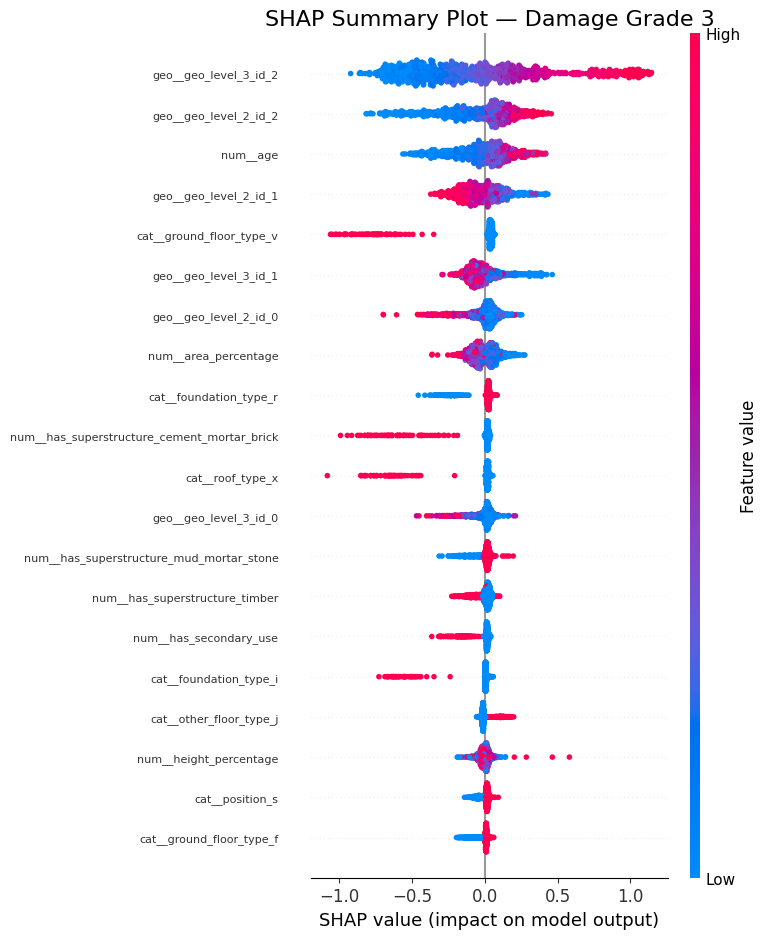

In [14]:
class_names = ['Damage Grade 1', 'Damage Grade 2', 'Damage Grade 3']

for i, class_name in enumerate(class_names):

    shap.summary_plot(
        shap_values[:, :, i], 
        X_sample_full_aligned,
        plot_type="dot",
        show=False
    )
    # Change feature label size
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=12) 

    plt.title(f"SHAP Summary Plot — {class_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


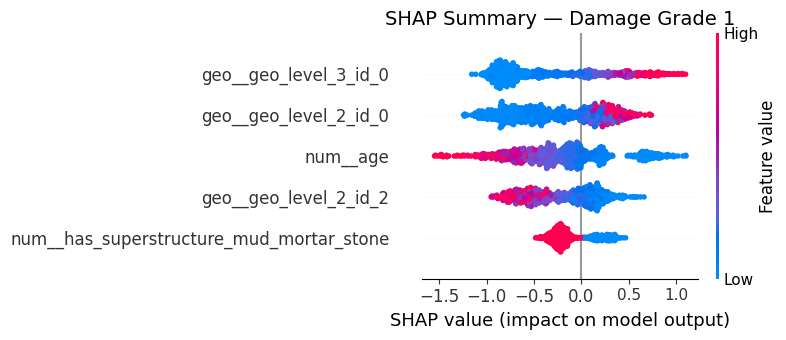

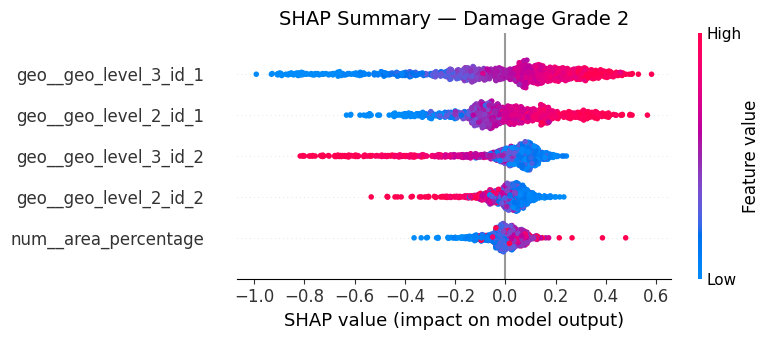

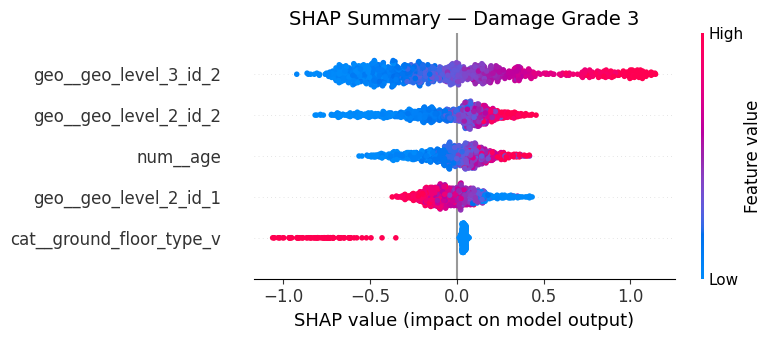

In [21]:
# Only plots top 5 features to include them in the write-up

for i, class_name in enumerate(class_names):
    # Create a smaller figure
    plt.figure(figsize=(1, 1))  # narrower figure
    shap.summary_plot(
        shap_values[:, :, i], 
        X_sample_full_aligned,
        plot_type="dot",
        max_display=5,
        show=False
    )
    # Adjust label sizes
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    plt.title(f"SHAP Summary — {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

